x<h1 style="margin-bottom:0"><center>DI 504: Fundementals of Deep Learning</center></h1>
<h2 style="margin-top:0"><center> Project - Implementation of DeepBind Model </center></h2>
<h3 style="margin-top:0"><center>Hüseyin Hilmi Kılınç </center></h3>
<h3 style="margin-top:0"><center> 2239275 </center></h3>
<h4 style="margin-top:0"><center><b>Due by June 20th, Friday at 23:59</b></center></h4>
<br>

### Problem Definition


### Importing necessary libraries

In [12]:
import numpy as np
import pandas as pd
import csv
import math
import random
import gzip
from scipy.stats import bernoulli
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import gzip, csv, random
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import roc_curve, auc as calc_auc
import matplotlib.pyplot as plt


# Device configuration
# 1) Select device: MPS if available, else CPU
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using Apple MPS device")
else:
    device = torch.device("cpu")
    print("Falling back to CPU")


Using Apple MPS device


## I. Utility Functions


In [3]:
bases='ACGT' #DNA bases
basesRNA='ACGU'#RNA bases (but it is unnecessary for this project)
dictReverse={'A':'T','C':'G','G':'C','T':'A','N':'N'} #dictionary to implement reverse-complement mode
reverse_mode= False # If reverse_complemet_mode is set to True, each original input sequence is duplicated with its reverse complement to account for strand ambiguity in DNA (i.e., both ATGC... and its reverse-complement GCAT... could potentially bind the TF).

#### **Sequence Padding and One-Hot Encoding DNA**
Prepares an input DNA sequence for convolutional motif scanning by:

	1.	Padding the sequence at both ends so that a filter of length motif_len can slide fully over every original position.
	2.	Converting each position into either a one-hot encoding (exact match → 1/0) or, for padding/unknowns (N), a uniform probability (0.25 for each base).

In [4]:
def padded_onehot_seq(sequence, motif_len, kind='DNA'):
    rows = len(sequence) + 2 * motif_len - 2  # total padded length
    S = np.empty([rows, 4])  # matrix of shape (rows, 4) to store one-hot or probabilistic encodings
    base = bases if kind == 'DNA' else basesRNA  # choose ACGT or ACGU (for RNA composition)

    for i in range(rows):
        for j in range(4):
            if i - motif_len + 1 < len(sequence) and sequence[i - motif_len + 1] == 'N' \
               or i < motif_len - 1 or i > len(sequence) + motif_len - 2:
                # Unknown base or in the padding region
                S[i, j] = np.float32(0.25)  # equal probability for A, C, G, T
            elif sequence[i - motif_len + 1] == base[j]:
                S[i, j] = np.float32(1)  # one-hot for matching base
            else:
                S[i, j] = np.float32(0)  # not the correct base

    return np.transpose(S)  # transpose to shape (4, sequence length)
example_padding = padded_onehot_seq("ATNGCA",motif_len=3) # N means unknown base from genomic sequence
print("A toy sequence example One-Hot encoding with padding:\n", example_padding)

A toy sequence example One-Hot encoding with padding:
 [[0.25 0.25 1.   0.   0.25 0.   0.   1.   0.25 0.25]
 [0.25 0.25 0.   0.   0.25 0.   1.   0.   0.25 0.25]
 [0.25 0.25 0.   0.   0.25 1.   0.   0.   0.25 0.25]
 [0.25 0.25 0.   1.   0.25 0.   0.   0.   0.25 0.25]]


#### Sequence Manipulation Utilities

* dinucshuffle(sequence) :
Splits the input into consecutive dinucleotides, shuffles those pairs at random (so you still get two‐base blocks, though not true overlapping dinuc preservation), and reassembles them into a new sequence. Use for generating simple negative controls.

* reverse_complement(seq) :
Maps each base to its Watson–Crick complement (A⇄T, C⇄G, N→N) and reverses the input string and then applies complement, yielding the classic reverse‐complement sequence used in DNA motif analyses.

In [5]:
# Dinucleotide-preserving shuffle
def dinuc_shuffle(sequence):
    di_mers = [sequence[i:i+2] for i in range(0, len(sequence), 2)]  # split into dinucleotides
    random.shuffle(di_mers) # shuffle preserving dinucleotide composition
    shuffled_seq = ''.join(di_mers)  # reassemble into a sequence
    return shuffled_seq

# Mapping reverse complement sequence input
def reverse_complement(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'N': 'N'}  # standard Watson-Crick base pairing
    seq = list(seq)
    seq.reverse()
    complseq = [complement[base] for base in seq]  # replace each base with its complement
    return ''.join(complseq)


### II. Data Loading with Augmentation and 3-Fold Splitting


In [6]:
class ChIP_exp:
    def __init__(
        self,
        filename: str,
        motif_len: int = 24,
        reverse_complement_mode: bool = False,
        n_splits: int = 3,
        random_seed: int = 0
    ):
        """
        - filename: path to gzipped TSV with sequence in column 3 (0-based index 2)
        - motif_len: filter length for seqtopad
        - reverse_complement_mode: if True, also include reverse-complement augmentations
        - n_splits: number of cross-validation folds (default 3)
        - random_seed: seed for reproducible shuffling/splits
        """
        self.filename = filename
        self.motif_len = motif_len
        self.rev_mode = reverse_complement_mode # For Data augmentation
        self.n_splits = n_splits
        self.seed = random_seed

    def openFile(self):
        # 1) Read and augment
        data = []
        with gzip.open(self.filename, 'rt') as fp:
            reader = csv.reader(fp, delimiter='\t')
            next(reader)  # skip header
            for row in reader:
                positive_seq = row[2] # third column includes DNA sequence
                onehot_encoded_positive_seq = padded_onehot_seq(positive_seq, self.motif_len)
                # always include the real sequence as positive
                data.append((onehot_encoded_positive_seq, 1)) # One-hot encoded positive sample (labeled as 1)

                # optionally include its reverse complement as also positive (For data augmentation part)
                if self.rev_mode:
                    rc_pos_seq = reverse_complement(positive_seq)
                    one_hot_encoded_rc_pos_seq = padded_onehot_seq(rc_pos_seq, self.motif_len)
                    data.append((one_hot_encoded_rc_pos_seq, 1))

                # add shuffled negatives (with or without reversing)
                # shuffle on the raw and on its reverse if rev_mode
                negative_seq = dinuc_shuffle(positive_seq)
                one_hot_encoded_negative_seq = padded_onehot_seq(negative_seq, self.motif_len)
                data.append((one_hot_encoded_negative_seq, 0)) # One-hot encoded negative (dinucleotide shuffled - labeled as 0)
                if self.rev_mode: # (also For data augmentation part)
                    rc_neq_seq = dinuc_shuffle(reverse_complement(positive_seq))
                    one_hot_encoded_rc_neqative_seq = padded_onehot_seq(rc_neq_seq, self.motif_len)
                    data.append((one_hot_encoded_rc_neqative_seq, 0))

        # 3) Build 3-fold splits using KFold
        # kf = KFold(n_splits=self.n_splits, shuffle=False, random_state=None)
        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.seed)
        splits = []
        indices = list(range(len(data)))
        for train_idx, valid_idx in kf.split(indices):
            train = [data[i] for i in train_idx]
            valid = [data[i] for i in valid_idx]
            splits.append((train, valid))

        # 4) Return list of folds plus the full dataset
        #    splits[0] = (fold1_train, fold1_valid), etc.
        return splits, data

    def openFile_test(self):
        test_dataset=[]
        with gzip.open(self.filename, 'rt') as data:
            next(data)
            reader = csv.reader(data,delimiter='\t')
            if not self.rev_mode:
                for row in reader:
                    pos_neg_seq_test = row[2]
                    label_test = row[3]
                    one_hot_encoded_seq = padded_onehot_seq(pos_neg_seq_test,self.motif_len)
                    test_dataset.append((one_hot_encoded_seq,label_test))
            else:
                for row in reader:
                    seq = row[2]
                    label_test = int(row[3])
                    one_hot_encoded_seq = padded_onehot_seq(seq, self.motif_len)
                    test_dataset.append((one_hot_encoded_seq, label_test))
                    one_hot_encoded_rc_seq = padded_onehot_seq(reverse_complement(seq), self.motif_len)
                    test_dataset.append((one_hot_encoded_rc_seq, label_test))
        return test_dataset

In [26]:
example_raw_sequences = pd.read_csv("encode/SP1_GM12878_SP1_HudsonAlpha_AC.seq.gz",sep='\t')
print("Example Experimental Raw Dataset:\n", raw_sequences)

Example Experimental Raw Dataset:
       FoldID         EventID  \
0          A  seq_00001_peak   
1          A  seq_00003_peak   
2          A  seq_00005_peak   
3          A  seq_00007_peak   
4          A  seq_00009_peak   
...      ...             ...   
17743      A  seq_18244_peak   
17744      A  seq_18245_peak   
17745      A  seq_18246_peak   
17746      A  seq_18247_peak   
17747      A  seq_18248_peak   

                                                     seq  Bound  
0      GTATCTGATTGGCTGCTAGCAGGCAGAGAAGGTATCTGATTGGCTG...      1  
1      ATCATTCTCTGTGCTGCTTCTACAGGTTAATACACGCTGATCTTCT...      1  
2      CGGCCTCGGCTTCACGTCTATTGGAAGGAACCGCTGTCTATCTCTA...      1  
3      TATCACGTCGATCACTGGTTCTTTCGATCTGTCGCTCAGCTAAAGA...      1  
4      CCGGCCTCCGGTAGGTTGCAACCCATGTCACTCAGGATGAATGGCT...      1  
...                                                  ...    ...  
17743  GGGGGTGGTCTTGTGGGACTGAGCCCTGAACCTGTGGTTTCTGAGG...      1  
17744  GATCCCACGCTGCGCTTTCGCCACGTCCTGACGGCTGCCCGATAA

In [28]:
chip_seq = ChIP_exp("encode/ELK1_GM12878_ELK1_(1277-1)_Stanford_AC.seq.gz") # Importing TF-ChIP-seq experimental sequence data
splits,alldataset = chip_seq.openFile()

print("Train splits:",len(splits[0][0]), len(splits[1][0]), len(splits[2][0])) # train sets
print("Validation splits:", len(splits[0][1]), len(splits[1][1]), len(splits[2][1])) # validation sets
print("Full dataset size:",len(alldataset))
print("Train shape:",splits[0][0][0][0].shape) #  Example train shape (4, 147) means 4 channels (A/C/G/T) by 147 positions (23 padding bases on each side of the 101-bp sequence).

Train splits: 6778 6779 6779
Validation splits: 3390 3389 3389
Full dataset size: 10168
Train shape: (4, 147)


In [29]:
# Define a custom Dataset wrapping ChIP-seq feature/label pairs
class chipseq_dataset(Dataset):

    def __init__(self,xy=None):
        self.x_data=np.asarray([el[0] for el in xy],dtype=np.float32) # Stack feature arrays into a NumPy array and cast to float32
        self.y_data =np.asarray([el[1] for el in xy ],dtype=np.float32)  # Stack labels into a NumPy array and cast to float32
        # Convert NumPy arrays to a PyTorch tensor
        self.x_data = torch.from_numpy(self.x_data)
        self.y_data = torch.from_numpy(self.y_data).view(-1, 1) # reshaping y_data
        self.len=len(self.x_data)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index] # Return the feature tensor and its corresponding label

    def __len__(self):
        return self.len # Return the total number of samples in the dataset

In [30]:
# Prepare lists to hold DataLoaders
train_dataloader = []
valid_dataloader = []
batch_size=64 # fixed batch size

# Iterate over each fold’s (train, valid) pair
for fold_idx, (train_xy, valid_xy) in enumerate(splits, start=1):
    # Wrap the raw (features, labels) lists into your dataset
    train_ds = chipseq_dataset(train_xy)
    valid_ds = chipseq_dataset(valid_xy)

    # Create DataLoader
    # shuffle training folds unless in reverse-complement mode
    train_splitloader = DataLoader(
        dataset=train_ds,
        batch_size=batch_size,
        shuffle=not reverse_mode
    )
    # validation loaders never shuffle
    valid_splitloader = DataLoader(
        dataset=valid_ds,
        batch_size=batch_size,
        shuffle=False
    )

    train_dataloader.append(train_splitloader)
    valid_dataloader.append(valid_splitloader)

# Optionally, build a DataLoader over the full dataset too:
full_ds     = chipseq_dataset(alldataset)
full_loader = DataLoader(full_ds, batch_size=batch_size, shuffle=False)

# Now we can index:
#   train_loaders[0], valid_loaders[0]  →  fold 1
#   train_loaders[1], valid_loaders[1]  →  fold 2
#   train_loaders[2], valid_loaders[2]  →  fold 3

### III. DeepBind Model Architecture Definition

This section defines the core DeepBind-inspired convolutional neural network (`ConvNet`) used to predict transcription factor binding from DNA sequences. The model includes:

- **1D Convolutional Filters (`wConv`)**: These detect motifs across the input sequence (encoded as 4-channel one-hot vectors).
- **Rectification Layer (`wRect`)**: Acts as a learnable threshold applied before the ReLU activation.
- **Pooling Options**: Global max pooling or combined max+average pooling (`poolType`), allowing different motif summarization strategies.
- **Fully Connected Layers**: Either a single-layer output (`nohidden`) or a hidden layer with 32 ReLU units (`hidden`), controlled by the `neuType` flag.
- **Dropout Regularization**: Applied optionally during training to reduce overfitting.
- **Reverse-Complement Handling**: If `reverse_mode` is enabled, the model takes both forward and reverse DNA strands and picks the one with the stronger predicted binding signal.
- **Custom Initialization**: The weights and biases are initialized from normal distributions with tunable standard deviations (`sigmaConv`, `sigmaNeu`), and L2 regularization terms (`beta1`, `beta2`, `beta3`) are added to the loss to encourage simpler models.

The model supports two forward paths:
- `forward_pass`: Applies conv → ReLU → pool → FC(+dropout).
- `forward`: Handles optional strand-aware inference using paired inputs.

In [31]:
# Randomly sampled during the hyperparameter tuning phase
def logsampler(a,b):
        x=np.random.uniform(low=0,high=1)
        y=10**((math.log10(b)-math.log10(a))*x + math.log10(a))
        return y

def sqrtsampler(a,b):

        x=np.random.uniform(low=0,high=1)
        y=(b-a)*math.sqrt(x)+a
        return y

# input of shape(batch_size,inp_chan,iW) - From your earlier print: (4, 147) → so for one sample, it’s 4 channels × 147 length
class ConvNet(nn.Module):
    def __init__(self, nummotif,motiflen,poolType,neuType,mode,dropprob,
                 learning_rate,momentum_rate,sigmaConv,sigmaNeu,
                 beta1,beta2,beta3,reverse_complemet_mode=reverse_mode):

        super(ConvNet, self).__init__()
        # Store meta-parameters
        self.poolType=poolType # pooling: 'max' or 'maxavg'
        self.neuType=neuType # hidden layer or not
        self.mode=mode  # 'training' or 'testing'
        self.reverse_complemet_mode=reverse_complemet_mode
        self.dropprob=dropprob
        self.learning_rate=learning_rate
        self.momentum_rate=momentum_rate
        self.sigmaConv=sigmaConv  # std dev for conv weight init
        self.sigmaNeu=sigmaNeu # std dev for fc layer init
        self.beta1, self.beta2, self.beta3 = beta1, beta2, beta3  # for regularization
        # Convolutional filters (motif detectors)
        self.wConv=torch.randn(nummotif,4,motiflen).to(device) # (16,4,24) -> nummotif(kernels), 4(input channels since 4 DNA composition), motiflen (how many consecutive bases the filter spans)
        torch.nn.init.normal_(self.wConv,mean=0,std=self.sigmaConv)
        self.wConv.requires_grad=True

        # Rectification bias (threshold before ReLU)
        self.wRect=torch.randn(nummotif).to(device)
        torch.nn.init.normal_(self.wRect)
        self.wRect=-self.wRect # Negated threshold bias
        self.wRect.requires_grad=True

        # If no hidden layer: output directly from pooled vector
        if neuType=='nohidden':

            if poolType=='maxavg':
                self.wNeu=torch.randn(2 * nummotif,1).to(device)
            else:
                self.wNeu=torch.randn(nummotif,1).to(device)
            self.wNeuBias=torch.randn(1).to(device)
            torch.nn.init.normal_(self.wNeu,mean=0,std=self.sigmaNeu)
            torch.nn.init.normal_(self.wNeuBias,mean=0,std=self.sigmaNeu)
        # With hidden layer (32 ReLU units)
        else:
            if poolType=='maxavg':
                self.wHidden=torch.randn(2 * nummotif,32).to(device)
            else:

                self.wHidden=torch.randn(nummotif,32).to(device)
            self.wNeu=torch.randn(32,1).to(device)
            self.wNeuBias=torch.randn(1).to(device)
            self.wHiddenBias=torch.randn(32).to(device)
            torch.nn.init.normal_(self.wNeu,mean=0,std=self.sigmaNeu)
            torch.nn.init.normal_(self.wNeuBias,mean=0,std=self.sigmaNeu)
            torch.nn.init.normal_(self.wHidden,mean=0,std=0.3)
            torch.nn.init.normal_(self.wHiddenBias,mean=0,std=0.3)


            self.wHidden.requires_grad=True
            self.wHiddenBias.requires_grad=True

        self.wNeu.requires_grad=True
        self.wNeuBias.requires_grad=True

    # Handle reverse complements (for pairwise inputs)
    def divide_two_tensors(self,x):
        # Input has shape (batch*2, channels, length) → separate forward and reverse strands
        l=torch.unbind(x)
        list1=[l[2*i] for i in range(int(x.shape[0]/2))]
        list2=[l[2*i+1] for i in range(int(x.shape[0]/2))]
        x1=torch.stack(list1,0)
        x2=torch.stack(list2,0)
        return x1,x2

    # One pass through the conv + pool + FC layers
    def forward_pass(self,x,mask=None,use_mask=False): # input of shape(batch_size, 4, sequence_length)

        conv=F.conv1d(x, self.wConv, bias=self.wRect, stride=1, padding=0)   # 1D convolution across sequence, lets say seq length= 147, ((147-24)/1 +1 = 124 )
        rect=conv.clamp(min=0) # Apply ReLU (rectification stage) #
        maxPool, _ = torch.max(rect, dim=2)  # Global max pooling, for each of the 16 filters, keep only the highest activation score across the 124 positions
        if self.poolType=='maxavg': # Optional average pooling
            avgPool= torch.mean(rect, dim=2)
            pool=torch.cat((maxPool, avgPool), 1)
        else:
            pool=maxPool

        # Apply Fully Connected Layers
        if(self.neuType=='nohidden'):
            if self.mode=='training':
                if  not use_mask:
                  mask=bernoulli.rvs(self.dropprob, size=len(pool[0]))
                  mask=torch.from_numpy(mask).float().to(device)
                pooldrop=pool*mask
                out=pooldrop @ self.wNeu # Matrix Multiplication
                out.add_(self.wNeuBias)
            else:
                out=self.dropprob*(pool @ self.wNeu)
                out.add_(self.wNeuBias)
        else:
            hid=pool @ self.wHidden
            hid.add_(self.wHiddenBias)
            hid=hid.clamp(min=0)
            if self.mode=='training':
                if  not use_mask:
                  mask=bernoulli.rvs(self.dropprob, size=len(hid[0]))
                  mask=torch.from_numpy(mask).float().to(device)
                hiddrop=hid*mask
                out=self.dropprob*(hid @ self.wNeu)
                out.add_(self.wNeuBias)
            else:
                out=self.dropprob*(hid @ self.wNeu)
                out.add_(self.wNeuBias)
        return out,mask

    # Full Forward Pass (Handles strand ambiguity)
    def forward(self, x):

        if not  self.reverse_complemet_mode:
            out,_=self.forward_pass(x)

        else:
            # Forward and reverse strands are split in pairs
            x1,x2=self.divide_two_tensors(x)
            out1,mask=self.forward_pass(x1)
            out2,_=self.forward_pass(x2,mask,True)
            out=torch.max(out1, out2)  # take strand with highest binding score

        return out



### IV. Hyperparameter Search and Calibration Phase

This block conducts a randomized hyperparameter search to identify the best-performing DeepBind model configuration. It performs the following:

- Randomly samples values for hyperparameters such as dropout rate, learning rate, momentum, initialization noise, and regularization strengths.
- Trains the model for multiple folds (3-fold cross-validation) and evaluates performance using Area Under the Curve (AUC).
- Stores the best combination of hyperparameters that yields the highest average AUC across folds.
- Saves the optimal settings in a `.pth` file for later use in final model training.

This phase is essential for tuning the model to avoid overfitting or underfitting and to achieve robust motif prediction across diverse sequences.

For each combination, the model is:

	1.	Initialized and trained for up to 20000 steps.
	2.	Evaluated every 4000 steps.
	3.	Tracked by validation AUC.
	4.	Compared to previous best.
	5.	If it’s better → hyperparameters are saved.

In [11]:
# Calibration Stage ;  Randomly sample different combinations of hyperparameters

print("Using Apple MPS device", device)
# Hyper parameters - Default training configuration
nummotif = 16 # Default Output Channel, number of motif filters to discover (Each one is intended to learn to recognize a different DNA motif)
motiflen = 24 # Default Kernel size, the length of the motif to detect (filter width in the 1D convolution)

def random_hyperparams_search(train_dataloader,valid_dataloader,device,nummotif=16,motiflen=24, num_trials=5):
    learning_steps_list = [4000, 8000, 12000, 16000, 20000] # Predefined list of learning steps to evaluate
    best_AUC = 0  # Initialize best AUC score
    # Try 5 random hyperparameter combinations (Random Search over the hyperparameter space, instead of doing an exhaustive grid search (which is expensive))
    for number in range(num_trials):

        # Randomly select pooling type ('max' or 'maxavg')
        pool_List = ['max', 'maxavg']
        random_pool = random.choice(pool_List)

        # Randomly select network type ('hidden' or 'nohidden')
        neuType_list = ['hidden', 'nohidden']
        random_neuType = random.choice(neuType_list)

        # Randomly select dropout probability
        dropoutList = [0.5, 0.75, 1.0]
        dropprob = random.choice(dropoutList)

        # Sample learning-related hyperparameters on log or sqrt scale
        learning_rate = logsampler(0.0005, 0.05)
        momentum_rate = sqrtsampler(0.95, 0.99)
        sigmaConv = logsampler(1e-7, 1e-3)
        sigmaNeu = logsampler(1e-5, 1e-2)

        # Sample L2 regularization weights (beta1, beta2, beta3)
        beta1 = logsampler(1e-15, 1e-3)
        beta2 = logsampler(1e-10, 1e-3)
        beta3 = logsampler(1e-10, 1e-3)

        model_auc = [[], [], []]  # To store AUCs for each fold

        # 3-fold cross-validation
        for kk in range(3):
            # Initialize a new model with current sampled hyperparameters
            model = ConvNet(nummotif, motiflen, random_pool, random_neuType, 'training', dropprob,
                            learning_rate, momentum_rate, sigmaConv, sigmaNeu,
                            beta1, beta2, beta3, reverse_complemet_mode=reverse_mode).to(device)

            # Create optimizer with appropriate parameters
            if random_neuType == 'nohidden':
                optimizer = torch.optim.SGD(
                    [model.wConv, model.wRect, model.wNeu, model.wNeuBias],
                    lr=model.learning_rate, momentum=model.momentum_rate, nesterov=True
                )
            else:
                optimizer = torch.optim.SGD(
                    [model.wConv, model.wRect, model.wNeu, model.wNeuBias, model.wHidden, model.wHiddenBias],
                    lr=model.learning_rate, momentum=model.momentum_rate, nesterov=True
                )

            train_loader = train_dataloader[kk]
            valid_loader = valid_dataloader[kk]
            learning_steps = 0  # Reset training step counter

            while learning_steps <= 20000:
                model.mode = 'training'  # Set model to training mode

                for i, (data, target) in enumerate(train_loader):
                    data = data.to(device)
                    target = target.to(device)

                    # If reverse mode is on, reduce label shape
                    if model.reverse_complemet_mode:
                        target_2 = torch.randn(int(target.shape[0]/2), 1)
                        for i in range(target_2.shape[0]):
                            target_2[i] = target[2*i] # the duplicated labels (forward + reverse) back into a single label
                        target = target_2.to(device)

                    output = model(data)  # Forward pass

                    # Compute loss with L2 regularization
                    if model.neuType == 'nohidden':
                        loss = F.binary_cross_entropy(torch.sigmoid(output), target) + \
                               model.beta1 * model.wConv.norm() + \
                               model.beta3 * model.wNeu.norm()
                    else:
                        loss = F.binary_cross_entropy(torch.sigmoid(output), target) + \
                               model.beta1 * model.wConv.norm() + \
                               model.beta2 * model.wHidden.norm() + \
                               model.beta3 * model.wNeu.norm()
                    # Backpropagation Step:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    learning_steps += 1

                    # This mimics epoch-level validation AUC, but here it’s done every 4000 mini-batches instead.
                    if learning_steps % 4000 == 0:
                        with torch.no_grad():
                            model.mode = 'test'
                            auc = []
                            for i, (data, target) in enumerate(valid_loader):
                                data = data.to(device)
                                target = target.to(device)

                                if model.reverse_complemet_mode:
                                    target_2 = torch.randn(int(target.shape[0]/2), 1)
                                    for i in range(target_2.shape[0]):
                                        target_2[i] = target[2*i]  # The duplicated labels (forward + reverse) back into a single label
                                    target = target_2.to(device)

                                output = model(data)
                                pred_sig = torch.sigmoid(output)
                                pred = pred_sig.cpu().detach().numpy().reshape(output.shape[0]) #
                                labels = target.cpu().numpy().reshape(output.shape[0])
                                auc.append(metrics.roc_auc_score(labels, pred))

                            model_auc[kk].append(np.mean(auc))
                            print('AUC performance when training fold number', kk+1,
                                  'using', learning_steps_list[len(model_auc[kk])-1],
                                  'learning steps =', np.mean(auc))

        print('                   ##########################################               ')

        # After evaluating all folds, track the best overall configuration
        for n in range(5):
            AUC = (model_auc[0][n] + model_auc[1][n] + model_auc[2][n]) / 3
            if AUC > best_AUC:
                best_AUC = AUC
                best_learning_steps = learning_steps_list[n]
                best_LearningRate = model.learning_rate
                best_LearningMomentum = model.momentum_rate
                best_neuType = model.neuType
                best_poolType = model.poolType
                best_sigmaConv = model.sigmaConv
                best_dropprob = model.dropprob
                best_sigmaNeu = model.sigmaNeu
                best_beta1 = model.beta1
                best_beta2 = model.beta2
                best_beta3 = model.beta3

    # Print and save the best hyperparameter configuration
    print('best_poolType=', best_poolType)
    print('best_neuType=', best_neuType)
    print('best_AUC=', best_AUC)
    print('best_learning_steps=', best_learning_steps)
    print('best_LearningRate=', best_LearningRate)
    print('best_LearningMomentum=', best_LearningMomentum)
    print('best_sigmaConv=', best_sigmaConv)
    print('best_dropprob=', best_dropprob)
    print('best_sigmaNeu=', best_sigmaNeu)
    print('best_beta1=', best_beta1)
    print('best_beta2=', best_beta2)
    print('best_beta3=', best_beta3)

    # Save the best configuration to file for later training use
    best_hyperparameters = {
        'best_poolType': best_poolType,
        'best_neuType': best_neuType,
        'best_learning_steps': best_learning_steps,
        'best_LearningRate': best_LearningRate,
        'best_LearningMomentum': best_LearningMomentum,
        'best_sigmaConv': best_sigmaConv,
        'best_dropprob': best_dropprob,
        'best_sigmaNeu': best_sigmaNeu,
        'best_beta1': best_beta1,
        'best_beta2': best_beta2,
        'best_beta3': best_beta3
    }

    torch.save(best_hyperparameters, f"best_hyperpamarameters_{nummotif}_{motiflen}.pth")
best_params = random_hyperparams_search(train_dataloader,valid_dataloader,device,nummotif=16,motiflen=24, num_trials=5)

Using Apple MPS device mps
AUC performance when training fold number 1 using 4000 learning steps = 0.8226815392334564
AUC performance when training fold number 1 using 8000 learning steps = 0.8211621302577231
AUC performance when training fold number 1 using 12000 learning steps = 0.817389082252391
AUC performance when training fold number 1 using 16000 learning steps = 0.8183264098524595
AUC performance when training fold number 1 using 20000 learning steps = 0.8179476765629444
AUC performance when training fold number 2 using 4000 learning steps = 0.8321437840564156
AUC performance when training fold number 2 using 8000 learning steps = 0.8235438349040096
AUC performance when training fold number 2 using 12000 learning steps = 0.8185642900951471
AUC performance when training fold number 2 using 16000 learning steps = 0.8194135655296311
AUC performance when training fold number 2 using 20000 learning steps = 0.8164297565120023
AUC performance when training fold number 3 using 4000 lea

### V. Final Training on Full Dataset with Best Hyperparameters

In this section, I load the best hyperparameter configuration identified during the tuning phase and retrain the DeepBind model on the full dataset. Specifically:

- I instantiate six models (`range(6)`) using the same optimized settings to increase the chance of capturing a robust training outcome due to the stochastic nature of initialization.
- For each model, training is performed using the full dataset (`full_loader`) up to the best number of learning steps.
- After training, each model is evaluated on the full dataset, and AUC is used as the selection metric.
- The best-performing model (highest AUC) is saved to path (`MyModel_2_2.pth`) for final testing and interpretation.

This stage ensures that the final model used for prediction has been trained under optimal conditions on all available data.

In [16]:
# Pick the best configuration (i.e., the best combination of the above) and train the model on full training data using that setting.
def train_full_dataset_best_params(full_loader,nummotif,motiflen,device):

    # Load best hyperparameters found during tuning
    best_hyperparameters = torch.load(f'best_hyperpamarameters_{nummotif}_{motiflen}.pth')
    # Unpack the best hyperparameters
    best_poolType = best_hyperparameters['best_poolType']
    best_neuType = best_hyperparameters['best_neuType']
    best_learning_steps = best_hyperparameters['best_learning_steps']
    best_LearningRate = best_hyperparameters['best_LearningRate']
    best_dropprob = best_hyperparameters['best_dropprob']
    best_LearningMomentum = best_hyperparameters['best_LearningMomentum']
    best_sigmaConv = best_hyperparameters['best_sigmaConv']
    best_sigmaNeu = best_hyperparameters['best_sigmaNeu']
    best_beta1 = best_hyperparameters['best_beta1']
    best_beta2 = best_hyperparameters['best_beta2']
    best_beta3 = best_hyperparameters['best_beta3']

    best_AUC = 0  # Initialize best AUC to track best performing model
    # Train and evaluate 6 models with the same best configuration
    for number_models in range(6):

        # Create model using best parameters
        model = ConvNet(nummotif, motiflen, best_poolType, best_neuType, 'training',
                        best_dropprob, best_LearningRate, best_LearningMomentum,
                        best_sigmaConv, best_sigmaNeu,
                        best_beta1, best_beta2, best_beta3,
                        reverse_complemet_mode=False).to(device)

        # Select optimizer based on architecture
        if model.neuType == 'nohidden':
            optimizer = torch.optim.SGD(
                [model.wConv, model.wRect, model.wNeu, model.wNeuBias],
                lr=model.learning_rate,
                momentum=model.momentum_rate,
                nesterov=True
            )
        else:
            optimizer = torch.optim.SGD(
                [model.wConv, model.wRect, model.wNeu, model.wNeuBias,
                 model.wHidden, model.wHiddenBias],
                lr=model.learning_rate,
                momentum=model.momentum_rate,
                nesterov=True
            )

        train_loader = full_loader  # Use full dataset for training
        valid_loader = full_loader  # Evaluate on full dataset as a proxy
        learning_steps = 0

        # Training loop
        while learning_steps <= best_learning_steps:
            for i, (data, target) in enumerate(train_loader):
                data = data.to(device)
                target = target.to(device)

                # Handle reverse complement if enabled (not used here)
                if model.reverse_complemet_mode:
                    target_2 = torch.randn(int(target.shape[0]/2), 1)
                    for i in range(target_2.shape[0]):
                        target_2[i] = target[2*i]
                    target = target_2.to(device)

                # Forward pass
                output = model(data)

                # Compute loss with L2 regularization
                if model.neuType == 'nohidden':
                    loss = F.binary_cross_entropy(torch.sigmoid(output), target) + \
                           model.beta1 * model.wConv.norm() + \
                           model.beta3 * model.wNeu.norm()
                else:
                    loss = F.binary_cross_entropy(torch.sigmoid(output), target) + \
                           model.beta1 * model.wConv.norm() + \
                           model.beta2 * model.wHidden.norm() + \
                           model.beta3 * model.wNeu.norm()

                # Backpropagation and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                learning_steps += 1

        # Evaluation on full dataset
        with torch.no_grad():
            model.mode = 'test'
            auc = []
            for i, (data, target) in enumerate(valid_loader):
                data = data.to(device)
                target = target.to(device)

                if model.reverse_complemet_mode:
                    target_2 = torch.randn(int(target.shape[0]/2), 1)
                    for i in range(target_2.shape[0]):
                        target_2[i] = target[2*i]
                    target = target_2.to(device)

                # Forward pass and AUC calculation
                output = model(data)
                pred_sig = torch.sigmoid(output)
                pred = pred_sig.cpu().detach().numpy().reshape(output.shape[0])
                labels = target.cpu().numpy().reshape(output.shape[0])
                auc.append(metrics.roc_auc_score(labels, pred))

            # Compute and print mean AUC across batches
            AUC_training = np.mean(auc)
            print('AUC for model', number_models, '=', AUC_training)

            # Save model if it's the best so far
            if AUC_training > best_AUC:
                print("Saving current best model!")
                state = {
                    'conv': model.wConv,
                    'rect': model.wRect,
                    'wNeu': model.wNeu,
                    'wNeuBias': model.wNeuBias
                }

                if model.neuType == 'hidden':
                    state['wHidden'] = model.wHidden
                    state['wHiddenBias'] = model.wHiddenBias
                torch.save(state, "MyModel_2_2.pth")
                best_AUC = AUC_training
    return best_AUC

# Execute training on full dataset
best_full_AUC = train_full_dataset_best_params(full_loader,nummotif,motiflen, device)
print(f"\nBest AUC on full dataset: {best_full_AUC:.4f}")

AUC for model 0 = 0.8273687939208703
Saving current best model!
AUC for model 1 = 0.8471863317850725
Saving current best model!
AUC for model 2 = 0.8074944747946348
AUC for model 3 = 0.8481415856436914
Saving current best model!
AUC for model 4 = 0.7987091099706392
AUC for model 5 = 0.864931917637338
Saving current best model!
Best AUC on full dataset: 0.8649


### VI. Model Reloading and Validation Evaluation

This section loads the best-performing trained DeepBind model from disk and evaluates it on the validation set (which, in this implementation, is the full training set reused for evaluation). Specifically:

- The model weights saved in `MyModel_2_2.pth` are reloaded.
- A new model instance is created using the same architecture and hyperparameters.
- The weights (`wConv`, `wHidden`, etc.) are manually restored from the checkpoint file.
- The model is run in inference mode (`torch.no_grad()` + `mode='test'`).
- Predictions are computed across all validation data.
- The ROC AUC metric is used to quantify prediction quality.

This ensures consistency between training and inference and allows for robust final validation of the model’s performance before testing on unseen data.

In [18]:
# Load the saved weights (conv filters, hidden layer, biases, etc.)
checkpoint = torch.load('MyModel_2_2.pth')

def eval_validset(valid_loader,nummotif, motiflen, device):
    # Load best hyperparameters found during tuning
    best_hyperparameters = torch.load(f'best_hyperpamarameters_{nummotif}_{motiflen}.pth')
    # Unpack the best hyperparameters
    best_poolType = best_hyperparameters['best_poolType']
    best_neuType = best_hyperparameters['best_neuType']
    best_learning_steps = best_hyperparameters['best_learning_steps']
    best_LearningRate = best_hyperparameters['best_LearningRate']
    best_dropprob = best_hyperparameters['best_dropprob']
    best_LearningMomentum = best_hyperparameters['best_LearningMomentum']
    best_sigmaConv = best_hyperparameters['best_sigmaConv']
    best_sigmaNeu = best_hyperparameters['best_sigmaNeu']
    best_beta1 = best_hyperparameters['best_beta1']
    best_beta2 = best_hyperparameters['best_beta2']
    best_beta3 = best_hyperparameters['best_beta3']

    # Recreate the exact same model structure with 'test' mode (no dropout)
    model = ConvNet(
        nummotif, motiflen, best_poolType, best_neuType, 'test',
        best_LearningRate, best_LearningMomentum, best_sigmaConv,
        best_dropprob, best_sigmaNeu,
        best_beta1, best_beta2, best_beta3,
        reverse_complemet_mode=reverse_mode  # use same reverse mode as training
    ).to(device)

    # Manually restore the weights from checkpoint (PyTorch manual param loading)
    model.wConv = checkpoint['conv']
    model.wRect = checkpoint['rect']
    # model.wHidden = checkpoint['wHidden']
    # model.wHiddenBias = checkpoint['wHiddenBias']
    model.wNeu = checkpoint['wNeu']
    model.wNeuBias = checkpoint['wNeuBias']

    # Inference (no gradients needed)
    with torch.no_grad():
        model.mode = 'test'  # explicitly set model mode to 'test' (affects dropout)

        auc = []  # list to collect AUC scores from all batches

        # Iterate through the validation loader (previously built from full data)
        for i, (data, target) in enumerate(valid_loader):
            data = data.to(device)
            target = target.to(device)

            # If reverse complement mode is on, merge duplicate labels
            if model.reverse_complemet_mode:
                target_2 = torch.randn(int(target.shape[0] / 2), 1)
                for i in range(target_2.shape[0]):
                    target_2[i] = target[2 * i]
                target = target_2.to(device)

            # Forward pass: generate model predictions
            output = model(data)

            # Apply sigmoid to get probability predictions (from raw logits)
            pred_sig = torch.sigmoid(output)

            # Move predictions to CPU, detach from graph, convert to NumPy and flatten
            pred = pred_sig.cpu().detach().numpy().reshape(output.shape[0])

            # Do the same for labels
            labels = target.cpu().numpy().reshape(output.shape[0])

            # Compute ROC AUC for this batch and add to the list
            auc.append(metrics.roc_auc_score(labels, pred))

        # Compute final average AUC across all batches
        AUC_training = np.mean(auc)
        print(AUC_training)  # Display the final validation AUC

eval_validset(full_loader,nummotif, motiflen, device)

0.864931917637338


### VII. Final Model Evaluation on Completely Independent Test Set

In this section, the best DeepBind model is evaluated on a held-out **test dataset** to assess its generalization ability. The steps are:

- Load test sequences and labels from a separate `.gz` file using the `ChIP_exp` utility.
- Apply the same preprocessing and encoding (including reverse complement handling if enabled).
- Load the test data into a PyTorch `DataLoader` for batch-wise inference.
- Perform a forward pass for predictions using the already trained and restored DeepBind model.
- Apply `sigmoid()` to convert raw logits to probabilities.
- Calculate the **ROC AUC score** on the entire test set to quantify model performance on unseen data.

This final step provides a reliable estimate of how well the model will perform in real-world, unseen scenarios.

In [26]:

# Load test ChIP-seq dataset (Stanford_B replicate)
chipseq_test = ChIP_exp("encode/ELK1_GM12878_ELK1_(1277-1)_Stanford_B.seq.gz")

# Preprocess and padding with one-hot encode test sequences
test_data = chipseq_test.openFile_test()

# Wrap test data into custom PyTorch Dataset
test_dataset = chipseq_dataset(test_data)

# Use entire test set as a single batch (no shuffling, full batch size)
batchSize = test_dataset.__len__()
test_loader = DataLoader(dataset=test_dataset, batch_size=batchSize, shuffle=False)

def eval_independent_test_set(test_loader,nummotif, motiflen, device):
        # Load best hyperparameters found during tuning
    best_hyperparameters = torch.load(f'best_hyperpamarameters_{nummotif}_{motiflen}.pth')
    # Unpack the best hyperparameters
    best_poolType = best_hyperparameters['best_poolType']
    best_neuType = best_hyperparameters['best_neuType']
    best_learning_steps = best_hyperparameters['best_learning_steps']
    best_LearningRate = best_hyperparameters['best_LearningRate']
    best_dropprob = best_hyperparameters['best_dropprob']
    best_LearningMomentum = best_hyperparameters['best_LearningMomentum']
    best_sigmaConv = best_hyperparameters['best_sigmaConv']
    best_sigmaNeu = best_hyperparameters['best_sigmaNeu']
    best_beta1 = best_hyperparameters['best_beta1']
    best_beta2 = best_hyperparameters['best_beta2']
    best_beta3 = best_hyperparameters['best_beta3']

    # Recreate the exact same model structure with 'test' mode (no dropout)
    model = ConvNet(
        nummotif, motiflen, best_poolType, best_neuType, 'test',
        best_LearningRate, best_LearningMomentum, best_sigmaConv,
        best_dropprob, best_sigmaNeu,
        best_beta1, best_beta2, best_beta3,
        reverse_complemet_mode=reverse_mode  # use same reverse mode as training
    ).to(device)

    # Manually restore the weights from checkpoint (PyTorch manual param loading)
    model.wConv = checkpoint['conv']
    model.wRect = checkpoint['rect']
    # model.wHidden = checkpoint['wHidden']
    # model.wHiddenBias = checkpoint['wHiddenBias']
    model.wNeu = checkpoint['wNeu']
    model.wNeuBias = checkpoint['wNeuBias']

    # Evaluation: No gradient tracking required
    with torch.no_grad():
        model.mode = 'test'  # Ensure model behaves deterministically (no dropout)

        auc = []  # List to store AUC for this test batch
        auprc = []
        # Iterate through the test DataLoader (only one batch expected)
        for i, (data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)

            # Adjust labels if reverse complement mode is enabled
            if model.reverse_complemet_mode:
                target_2 = torch.randn(int(target.shape[0] / 2), 1)
                for i in range(target_2.shape[0]):
                    target_2[i] = target[2 * i]
                target = target_2.to(device)
            output = model(data)
            pred_sig = torch.sigmoid(output)
            pred = pred_sig.cpu().detach().numpy().reshape(output.shape[0])
            labels = target.cpu().numpy().reshape(output.shape[0])

            # Compute ROC AUC score for this batch and append to list
            auc.append(metrics.roc_auc_score(labels, pred))
            auprc.append(metrics.average_precision_score(labels, pred))
        # Compute final average AUC across batches (only one here)
        AUC_training = np.mean(auc)
        print(f"For {nummotif} motif filters and {motiflen} bp kernel size;")
        print(f"AUC on test data = {np.mean(auc):.3f}, \nAUPRC on test data= {np.mean(auprc):.3f}")
    return labels,pred
labels, pred  = eval_independent_test_set(test_loader,nummotif, motiflen, device)

For 16 motif filters and 24 bp kernel size;
AUC on test data = 0.937, 
AUPRC on test data= 0.943


#### ROC Curves

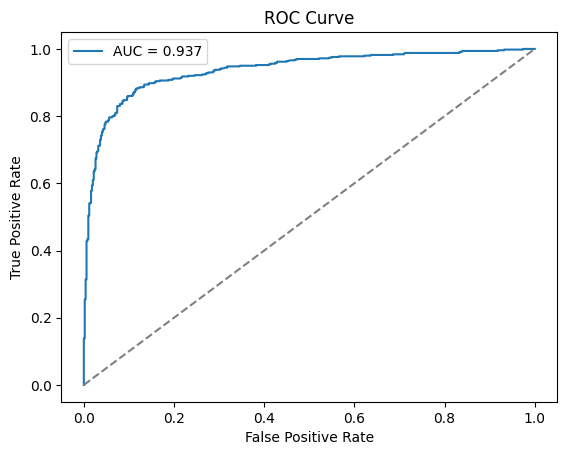

In [29]:
fpr, tpr, _ = metrics.roc_curve(labels, pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

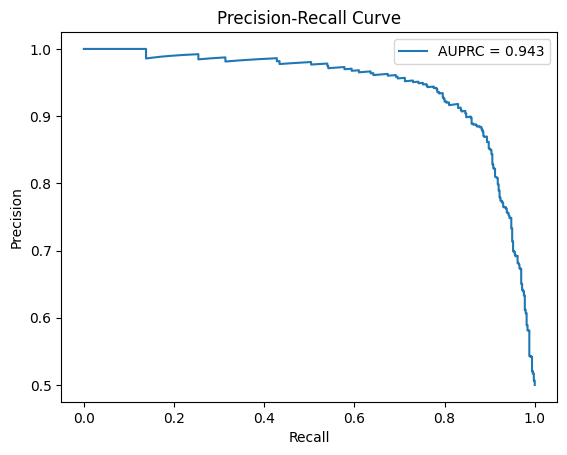

In [30]:

precision, recall, _ = metrics.precision_recall_curve(labels, pred)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f"AUPRC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()